In [93]:
from dataclasses import dataclass
import os
import itertools
from datetime import datetime

import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import seaborn as sns

In [32]:
## Helper classes
WGS84_LATLON_EPSG = 4326
EPS = 1e-8


_BaseBoundingBox = namedtuple('BoundingBox', ('left', 'bottom', 'right', 'top'))

class BoundingBox(_BaseBoundingBox):
    def contains(self, lat, lon):
        contains_lat =  self.bottom <= lat <= self.top
        contains_lon =  self.left <= lon <= self.right
        return contains_lat and contains_lon
    
    def intersects(self, bbox):
        y_overlap = self.bottom <= bbox.bottom <= self.top 
        y_overlap = y_overlap or self.bottom <= bbox.top <= self.top
        x_overlap = self.left <= bbox.left <= self.right 
        x_overlap = x_overlap or self.left <= bbox.right <= self.right
        return y_overlap and x_overlap
    
    @property
    def centre(self):
        lat = self.bottom + (self.top - self.bottom) / 2
        lon = self.left + (self.right - self.left) / 2
        return lat, lon
    
    @classmethod
    def from_bboxes(cls, bboxes):
        
        if len(bboxes) == 1:
            return BoundingBox(*bboxes[0])
        
        if len(bboxes) == 1:
            return bboxes[0]
    
        left = min([t.left for t in bboxes])
        right = max([t.right for t in bboxes])
        top = max([t.top for t in bboxes])
        bottom = min([t.bottom for t in bboxes])
        
        return BoundingBox(left, bottom, right, top)
        


class Tile(BoundingBox):
    pass

def _flatten_nested_list(x):
    return list(itertools.chain(*x))


def generate_random_tiles(n_tiles):
    rs = np.random.RandomState(0)
    widths = rs.uniform(10, 20, n_tiles)
    heights = rs.uniform(10, 20, n_tiles)
    lats = rs.uniform(-80, 60, n_tiles)
    lons = rs.uniform(-170, 160, n_tiles)


    # Build into bounds objects.
    tiles = []
    for lat, lon, w, h in zip(lats, lons, widths, heights):
        bbox = BoundingBox(lon, lat, lon+w, lat+h)
        tile = Tile(*bbox)
        tiles.append(tile)
    return tiles
    
def unique(x):
    return list(set(x))

In [76]:
DEFAULT_MAX_LEAF_SIZE = 10
DEFAULT_MAX_DEPTH = 10

        
class QuadTree:
    is_leaf = False
    _bbox = None
    
    def __init__(self, tiles, max_leaf_size=DEFAULT_MAX_LEAF_SIZE, depth=0, max_depth=DEFAULT_MAX_DEPTH):
        self.depth = depth
        self.children = []
        self.tiles = []
                
        # Early exit for leaf node due to few tiles or hitting max depth.
        if len(tiles) <= max_leaf_size or depth > max_depth:
            self.tiles = tiles
            self.is_leaf = True
            return
        
        
        # Otherwise, split into quads.
        for child_bbox in self.calculate_child_quads(tiles):
            child_tiles = [t for t in tiles if child_bbox.intersects(t)]
            if child_tiles:
                self.children.append(QuadTree(
                    child_tiles,
                    depth=self.depth+1,
                    max_depth=max_depth,
                    max_leaf_size=max_leaf_size,
                ))
                
        # No point having only a single child.
        if len(self.children) < 2:
            self.children = []
            self.tiles = tiles
            self.is_leaf = True
            print(f'Warning: removed children from {self}')
            return
                
                
    def calculate_child_quads(self, tiles):
        bbox = BoundingBox.from_bboxes(tiles)
        x_mid = bbox.left + (bbox.right - bbox.left) / 2
        y_mid = bbox.bottom + (bbox.top - bbox.bottom) / 2
        child_bboxes = [
            BoundingBox(bbox.left, bbox.bottom, x_mid, y_mid),
            BoundingBox(bbox.left, y_mid, x_mid, bbox.top),
            BoundingBox(x_mid, bbox.bottom, bbox.right, y_mid),
            BoundingBox(x_mid, y_mid, bbox.right, bbox.top),   
        ]
        return child_bboxes
        
        
        
    
        
    def query_single(self, lat, lon):
        if not self.bbox.contains(lat, lon):
            return []
        if self.is_leaf:
            return [t for t in self.tiles if t.contains(lat, lon)]
        else:
            return unique(_flatten_nested_list(c.query_single(lat, lon) for c in self.children))
        
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]
    
    
    @property
    def bbox(self):
        if not self._bbox:
            if self.tiles:
                self._bbox = BoundingBox.from_bboxes(self.tiles)
            elif self.children:
                self._bbox = BoundingBox.from_bboxes([c.bbox for c in self.children])
            else:
                raise ValueError('Uselesss node')
                
        return self._bbox
    
    
    def _flat_children(self):
        if self.is_leaf:
            return []
        else:
            return self.children + _flatten_nested_list([c._flat_children() for c in self.children])
    
    def __repr__(self):
        s =  self.__class__.__name__
        s += ' ['
        s += f'leaf={str(self.is_leaf)[0]}'
        s += f', depth={self.depth}'
        s += f', children={len(self.children)}'
        s += f', tiles={len(self.tiles)}]'
        # s += f', n_nodes={self._n_nodes}]'
        # s += f', n_leaves={self._n_leaves}]'
        s += ' ]'
        return s
        
    
    
                  

class BalancedQuadTree(QuadTree):
    def calculate_child_quads(self, tiles):
        # X mid is easy: pick the median of centroids.
        # c_lons = [t.centre[1] for t in tiles]
        # x_mid = np.median(c_lons)
        x_mid = np.median([t.right for t in tiles]) + EPS
        left_tiles = [t for t in tiles if t.left <= x_mid]
        right_tiles = [t for t in tiles if t not in left_tiles]

        # Split up each side: left.
        # left_c_lats = [t.centre[0] for t in left_tiles]
        # left_y_mid = np.median(left_c_lats)
        left_y_mid = np.median([t.top for t in tiles]) + EPS
        left_bottom_tiles = [t for t in left_tiles if t.bottom <= left_y_mid]
        left_top_tiles = [t for t in left_tiles if t not in left_bottom_tiles]

        # Split up each side: right.
        # right_c_lats = [t.centre[0] for t in right_tiles]
        # right_y_mid = np.median(right_c_lats)
        right_y_mid = np.median([t.top for t in tiles]) + EPS
        right_bottom_tiles = [t for t in right_tiles if t.bottom <= right_y_mid]
        right_top_tiles = [t for t in right_tiles if t not in right_bottom_tiles]

        child_bboxes = [
            BoundingBox.from_bboxes(left_bottom_tiles),
            BoundingBox.from_bboxes(left_top_tiles),
            BoundingBox.from_bboxes(right_bottom_tiles),
            BoundingBox.from_bboxes(right_top_tiles),
        ]

        return child_bboxes
    
    



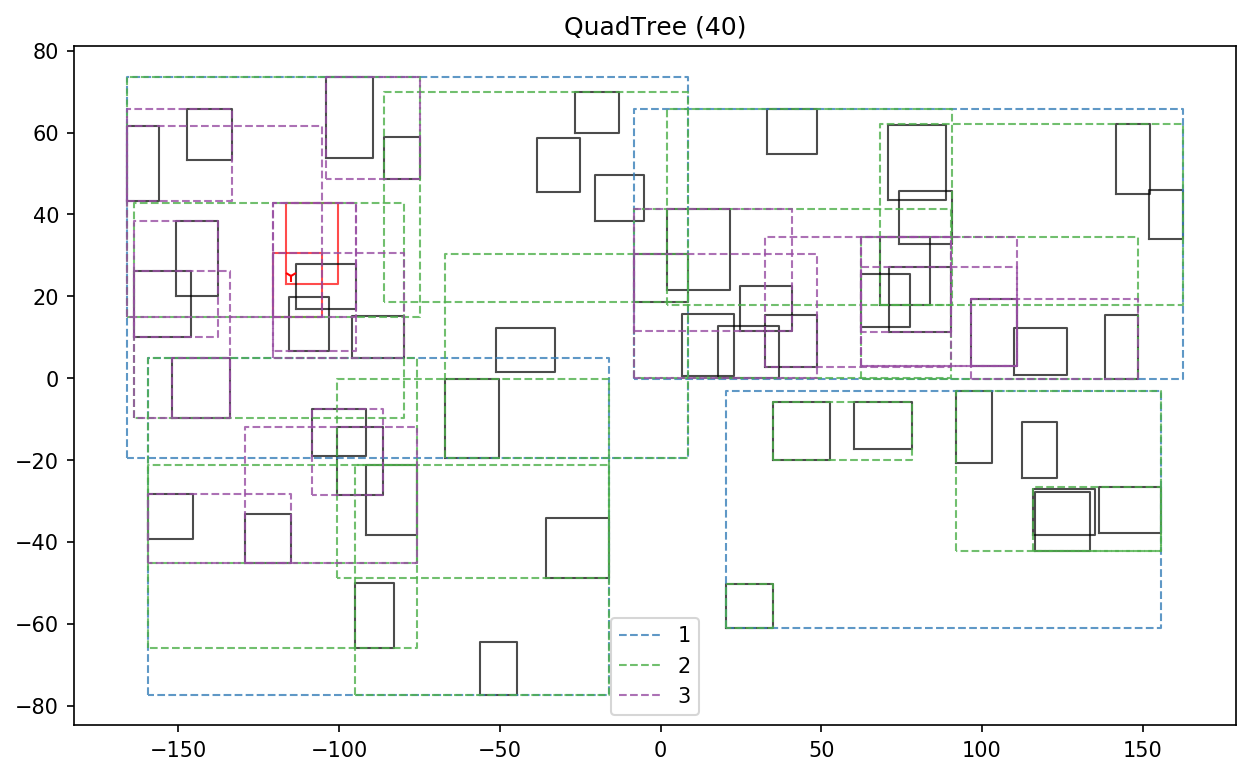

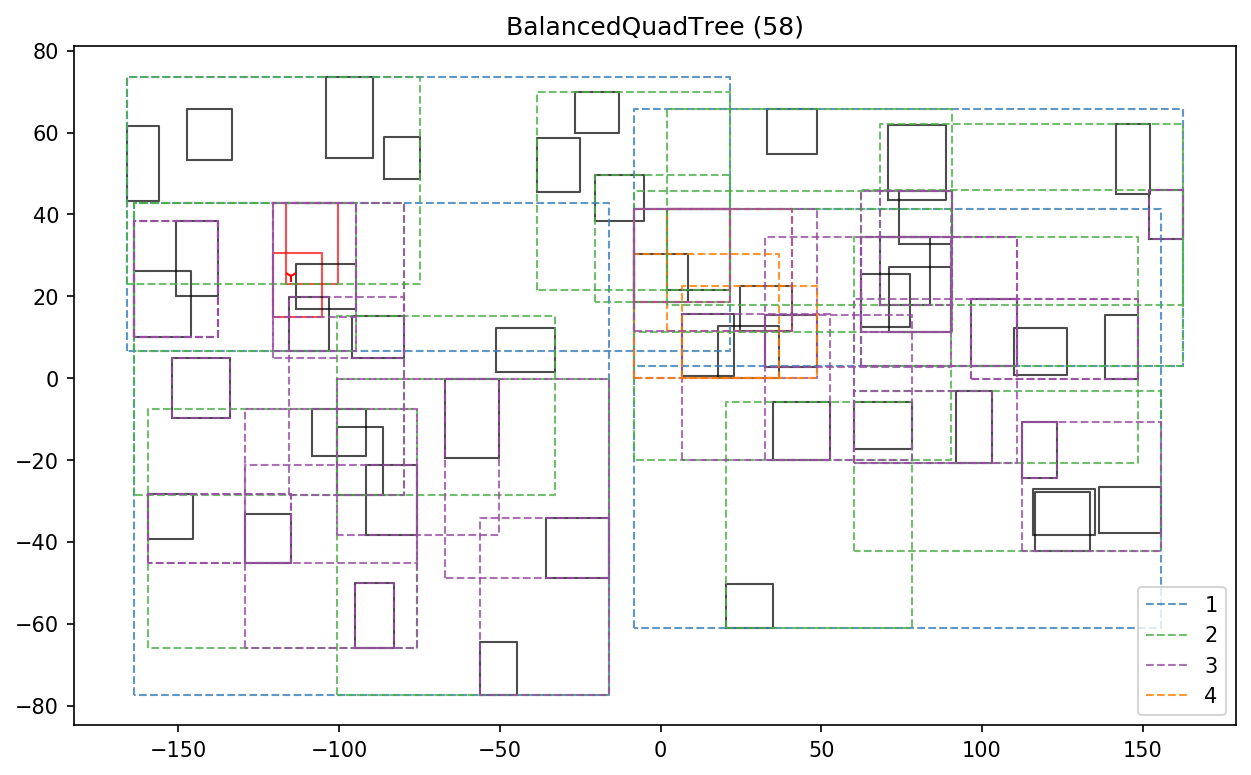

In [40]:
# Generate some test data.
n_tiles = 50
tiles = generate_random_tiles(n_tiles)
q_lat, q_lon = 25, -115

def _plot_bbox(bbox, ax, **kwargs):
    x = [bbox.left, bbox.left, bbox.right, bbox.right, bbox.left]
    y = [bbox.bottom, bbox.top, bbox.top, bbox.bottom, bbox.bottom]
    ax.plot(x, y, **kwargs)

for Sindex in [QuadTree, BalancedQuadTree]:
    sindex = Sindex(tiles, max_depth=15, max_leaf_size=5)
    q_tiles = sindex.query_single(q_lat, q_lon)

    # Plot tiles.
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    for t in tiles:
        c = 'r' if t in q_tiles else 'k'
        _plot_bbox(t, ax, color=c, alpha=0.7, lw=1)

    # Plot tree.
    nodes = sindex._flat_children()
    labelled_depths = set()
    for n in nodes:
        label = None
        if n.depth not in labelled_depths:
            label = n.depth
            labelled_depths.add(n.depth)
        c = list(plt.cm.Set1(n.depth)[:3]) + [0.8]
        _plot_bbox(n.bbox, ax, color=c, lw=1, label=label, ls='dashed')


    # Plot query.
    ax.plot(q_lon, q_lat, '1', c='r')
    ax.legend();
    
    ax.set_title(f'{Sindex.__name__} ({len(sindex._flat_children())})')

In [201]:
    
class NaiveIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.tiles = tiles
        
    def query_single(self, lat, lon):
        tiles = self.tiles
        tiles = [t for t in tiles if t.left <= lon]
        tiles = [t for t in tiles if t.right >= lon]
        tiles = [t for t in tiles if t.top >= lat]
        tiles = [t for t in tiles if t.bottom <= lat]
        return tiles
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]
    
class NumpyIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.lefts = np.array([t.left for t in tiles])
        self.rights = np.array([t.right for t in tiles])
        self.tops = np.array([t.top for t in tiles])
        self.bottoms = np.array([t.bottom for t in tiles])
        self.tiles = tiles
        
    def query_single(self, lat, lon):
        is_left = self.lefts <= lon
        is_right = self.rights >= lon
        is_top = self.tops >= lat
        is_bottom = self.bottoms <= lat
        is_res = is_left & is_right & is_top & is_bottom
        return list(itertools.compress(self.tiles, is_res))
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]


    
class NumpyArrayIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.lefts = np.array([t.left for t in tiles])
        self.rights = np.array([t.right for t in tiles])
        self.tops = np.array([t.top for t in tiles])
        self.bottoms = np.array([t.bottom for t in tiles])
        self.tiles = np.array(tiles, dtype=object)
        
    def query_single(self, lat, lon):
        is_left = self.lefts <= lon
        is_right = self.rights >= lon
        is_top = self.tops >= lat
        is_bottom = self.bottoms <= lat
        is_res = np.logical_and.reduce((is_left, is_right, is_top, is_bottom))
        res = self.tiles[is_res]
        res = [Tile(*b) for b in res]
        return res
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]

    
class NumpyReduceIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.lefts = np.array([t.left for t in tiles])
        self.rights = np.array([t.right for t in tiles])
        self.tops = np.array([t.top for t in tiles])
        self.bottoms = np.array([t.bottom for t in tiles])
        self.tiles = tiles
        
    def query_single(self, lat, lon):
        is_left = self.lefts <= lon
        is_right = self.rights >= lon
        is_top = self.tops >= lat
        is_bottom = self.bottoms <= lat
        is_res = np.logical_and.reduce((is_left, is_right, is_top, is_bottom))
        return list(itertools.compress(self.tiles, is_res))
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]
    
    
class NumpyIxIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.lefts = np.array([t.left for t in tiles])
        self.rights = np.array([t.right for t in tiles])
        self.tops = np.array([t.top for t in tiles])
        self.bottoms = np.array([t.bottom for t in tiles])
        self.tiles = tiles
        self.indices = np.arange(len(tiles))
        
    
        
    def query_single(self, lat, lon):
        ix = self.indices.copy()
        
        is_left = self.lefts[ix] <= lon
        ix = ix[is_left]
        if not ix.size:
            return []
        
        is_right = self.rights[ix] >= lon
        ix = ix[is_right]
        if not ix.size:
            return []
        
        is_top = self.tops[ix] >= lat
        ix = ix[is_top]
        if not ix.size:
            return []
        
        is_bottom = self.bottoms[ix] <= lat
        ix = ix[is_bottom]
        if not ix.size:
            return []
        
        return [self.tiles[i] for i in ix]
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]

    
class NumpyStackIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.tiles = tiles
        indices = np.arange(len(tiles))
        lefts = np.array([t.left for t in tiles])
        rights = np.array([t.right for t in tiles])
        tops = np.array([t.top for t in tiles])
        bottoms = np.array([t.bottom for t in tiles])
        self.stack = np.column_stack((indices, lefts, rights, tops, bottoms))
        
    
        
    def query_single(self, lat, lon):
        s = self.stack.copy()
        
        s = s[s[:, 1] <= lon, :]
        s = s[s[:, 2] >= lon, :]
        s = s[s[:, 3] >= lat, :]
        s = s[s[:, 4] <= lat, :]
        return [self.tiles[i] for i in s[:, 0].astype(int)]
    
    def query_multi(self, lats, lons):
        return [self.query_single(lat, lon) for lat, lon in zip(lats, lons)]
 

class NumpyHeuristicIxIndex:
    def __init__(self, tiles, *args, **kwargs):
        self.lefts = np.array([t.left for t in tiles])
        self.rights = np.array([t.right for t in tiles])
        self.tops = np.array([t.top for t in tiles])
        self.bottoms = np.array([t.bottom for t in tiles])
        self.tiles = tiles
        self.indices = np.arange(len(tiles))
        
        
    def query_single(self, lat, lon, ix=None):
        if ix is None:
            ix = self.indices.copy()
        else:
            ix = ix.copy()
        
        is_left = self.lefts[ix] <= lon
        ix = ix[is_left]
        if not ix.size:
            return []
        
        is_right = self.rights[ix] >= lon
        ix = ix[is_right]
        if not ix.size:
            return []
        
        is_top = self.tops[ix] >= lat
        ix = ix[is_top]
        if not ix.size:
            return []
        
        is_bottom = self.bottoms[ix] <= lat
        ix = ix[is_bottom]
        if not ix.size:
            return []
        
        return [self.tiles[i] for i in ix]
    
    def query_multi(self, lats, lons):
        n = len(lats)
        ix = None
        if n > 5:
            ix = self.indices.copy()
            ix = ix[self.lefts[ix] <= np.max(lons)]
            ix = ix[self.rights[ix] >= np.min(lons)]
            ix = ix[self.tops[ix] >= np.min(lats)]
            ix = ix[self.bottoms[ix] <= np.max(lats)]
            
        
        
        return [self.query_single(lat, lon, ix) for lat, lon in zip(lats, lons)]

In [202]:
def test_sindex(Sindex):


    # Single tile.
    tile = Tile(-10, -10, 10, 10)
    sindex = Sindex([tile])
    res = sindex.query_single(0, 0)
    assert tile in res

    # No tile.
    tile = Tile(-10, -10, 10, 10)
    sindex = Sindex([tile])
    res = sindex.query_single(50, 50)
    assert not res

    # Many.
    n_tiles = 100
    tiles = generate_random_tiles(n_tiles)
    sindex = Sindex(tiles, max_leaf_size=10, max_depth=8)

    # Check query.
    res = sindex.query_single(*tiles[0].centre)
    assert tiles[0] in res

    # Check single matches multi.
    res_1 = sindex.query_single(*tiles[0].centre)
    res_2 = sindex.query_multi([tiles[0].centre[0]], [tiles[0].centre[1]])[0]
    assert res_1 == res_2

    # Check all res valid.
    lats = [t.centre[0] for t in tiles]
    lons = [t.centre[1] for t in tiles]
    res_m = sindex.query_multi(lats, lons)
    for lat, lon, res in zip(lats, lons, res_m):
        for t in res:
            assert t.contains(lat, lon)
            
            
test_sindex(QuadTree)
test_sindex(BalancedQuadTree)
test_sindex(NaiveIndex)
test_sindex(NumpyIndex)
test_sindex(NumpyReduceIndex)
test_sindex(NumpyArrayIndex)
test_sindex(NumpyIxIndex)
test_sindex(NumpyStackIndex)
test_sindex(NumpyHeuristicIxIndex)

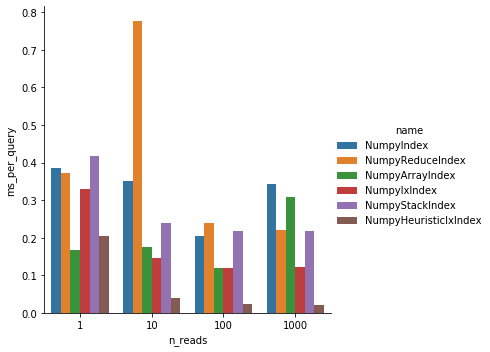

In [205]:
# Benchmark read speed.
classes = [NumpyIndex, NumpyReduceIndex, NumpyArrayIndex, NumpyIxIndex, NumpyStackIndex, NumpyHeuristicIxIndex]
n_tiles = 10000
n_reads = [1, 10, 100, 1000]
records = []
rs = np.random.RandomState()

tiles = generate_random_tiles(n_tiles)
for n_read in n_reads:
    reat_lats = rs.uniform(-20, 20, n_read)
    reat_lons = rs.uniform(-2, -1, n_read)
    for Sindex in classes:
        sindex = Sindex(tiles, max_depth=10, max_leaf_size=100)
        res = sindex.query_multi(reat_lats, reat_lons)
        start = datetime.utcnow()
        res = sindex.query_multi(reat_lats, reat_lons)
        stop = datetime.utcnow()
        
        r = {
            'name': Sindex.__name__,
            'query_time_ms': (stop - start).total_seconds() * 1000, 
            'ms_per_query': (stop - start).total_seconds() * 1000 / n_read, 
            'n_reads': n_read,
        }
        records.append(r)
        
        
df = pd.DataFrame.from_records(records)
g = sns.catplot(
    data=df,
    x='n_reads',
    y='ms_per_query',
    hue='name',
    kind='bar',
)

In [197]:
df

,name,query_time_ms,ms_per_query,n_reads
0,NumpyIndex,0.475,0.475000,1
1,NumpyReduceIndex,0.401,0.401000,1
2,NumpyArrayIndex,0.171,0.171000,1
3,NumpyIxIndex,0.242,0.242000,1
4,NumpyStackIndex,0.265,0.265000,1
5,NumpyIndex,5.220,0.522000,10
6,NumpyReduceIndex,3.006,0.300600,10
7,NumpyArrayIndex,1.061,0.106100,10
8,NumpyIxIndex,0.929,0.092900,10
9,NumpyStackIndex,1.914,0.191400,10


In [104]:
# # Benchmark build speed. All are roughly fine: QuatTree takes less than 1sec to to 10k.
# classes = [QuadTree, BalancedQuadTree, NaiveIndex, NumpyIndex]
# ns = [1, 10, 100, 1000, 10_000]
# records = []

# for n_tiles in ns:
#     tiles = generate_random_tiles(n_tiles)
#     for Sindex in classes:
#         start = datetime.utcnow()
#         sindex = Sindex(tiles, max_depth=10, max_leaf_size=100)
#         stop = datetime.utcnow()
        
#         r = {
#             'name': Sindex.__name__,
#             'build_time_ms': (stop - start).total_seconds() * 1000, 
#             'n_tiles': n_tiles,
#         }
#         records.append(r)
        
        
# pd.DataFrame.from_records(records)

## Todo

* Investigate skipped levels
* Balanced halving
* Numpy simple bool filter
* Numba early exit sorted loops
* Bench build
* Bench read
* Bench deserialise